# Step 1 - Data Processing

In [183]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import itertools
import time
import random

import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [184]:
data = 'C:/Users/prajw/Desktop/zillow_data.csv'
df = pd.read_csv(data, header = 0, parse_dates= True)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
1,58197,1002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
2,58200,1005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
3,58201,1007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
4,58202,1008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200


In [185]:
df.shape

(14723, 272)

In [186]:
area = pd.read_csv('C:/Users/prajw/Desktop/data/pricing/workshop/manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [187]:
area.shape

(139, 2)

In [188]:
ny = df.loc[df['City'] == 'New York']
ny.shape

(114, 272)

In [189]:
ny1 = pd.merge(ny, area, how = 'left', on = 'RegionName')
ny1.shape

(114, 273)

In [190]:
ny2 = ny1[ny1['District'].notnull()]
Brooklyn = ny2.loc[ny2['District'] == 'Brooklyn']
Manhattan = ny2.loc[ny2['District'] == 'Manhattan']
print('Brooklyn dataset: {0}'.format(Brooklyn.shape))
print('Manhattan dataset: {}'.format(Manhattan.shape))

Brooklyn dataset: (29, 273)
Manhattan dataset: (4, 273)


<h4>Only 4 Zipcodes are present in Manhattan dataset. Hence, we shall focus on Brooklyn dataset

In [191]:
Brooklyn.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
36,62014,11203,New York,NY,New York,Kings,424,149000.0,149200.0,149400.0,...,454600,458800,462800,468700,474500,475300,474800,481000,489900,Brooklyn
37,62015,11204,New York,NY,New York,Kings,357,201100.0,201100.0,201100.0,...,932800,946200,953800,957100,958900,963200,967900,972800,976400,Brooklyn
38,62016,11205,New York,NY,New York,Kings,1435,NaN,NaN,NaN,...,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400,Brooklyn
39,62019,11208,New York,NY,New York,Kings,309,126800.0,126700.0,126700.0,...,434400,437800,441600,440700,435400,429900,432300,442400,450600,Brooklyn
40,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn


In [192]:
columns_to_drop = Brooklyn[['RegionID','City','State','Metro','CountyName','SizeRank','District']]
brooklyn = Brooklyn.drop(labels = columns_to_drop, axis = 'columns')
brooklyn.shape

(29, 266)

In [193]:
brooklyn.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
36,11203,149000.0,149200.0,149400.0,149600.0,149700.0,149900.0,150100.0,150400.0,150900.0,...,450900,454600,458800,462800,468700,474500,475300,474800,481000,489900
37,11204,201100.0,201100.0,201100.0,201100.0,201100.0,201300.0,201600.0,202000.0,202700.0,...,921200,932800,946200,953800,957100,958900,963200,967900,972800,976400
38,11205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2267400,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400
39,11208,126800.0,126700.0,126700.0,126600.0,126600.0,126500.0,126400.0,126400.0,126500.0,...,432900,434400,437800,441600,440700,435400,429900,432300,442400,450600
40,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800


In [194]:
brooklyn[brooklyn['1996-04'].isnull()]['RegionName']

38    11205
47    11217
59    11231
64    11238
Name: RegionName, dtype: int64

In [195]:
def Transform(dataframe):
    melted = pd.melt(dataframe, id_vars = ['RegionName'], var_name = 'Month', value_name = 'MeanPrice')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset = ['MeanPrice'])
    return melted

In [196]:
brooklyn_data = Transform(brooklyn)
brooklyn_data.sort_values(by = ['RegionName'], ascending = True)
brooklyn_data.head()

,RegionName,Month,MeanPrice
0,11203,1996-04-01,149000.0
1,11204,1996-04-01,201100.0
3,11208,1996-04-01,126800.0
4,11209,1996-04-01,255700.0
5,11210,1996-04-01,187300.0


In [197]:
brooklyn_data.dtypes

RegionName             int64
Month         datetime64[ns]
MeanPrice            float64
dtype: object

In [198]:
brooklyn_data.set_index(keys = 'Month', inplace = True)

In [199]:
brooklyn_data.head()

,RegionName,MeanPrice
Month,,
1996-04-01,11203,149000.0
1996-04-01,11204,201100.0
1996-04-01,11208,126800.0
1996-04-01,11209,255700.0
1996-04-01,11210,187300.0


In [200]:
brooklyn_data.shape

(7313, 2)

<h1>Step 2 - Data Exploration and Visualization

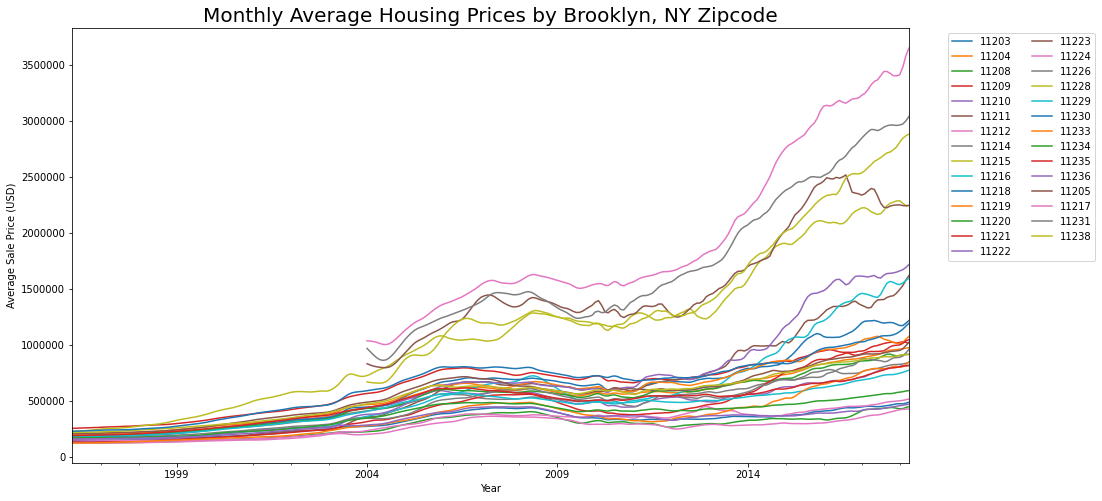

In [201]:
for zipcode in brooklyn_data.RegionName.unique():
    temp_df = brooklyn_data[brooklyn_data.RegionName == zipcode]
    temp_df['MeanPrice'].plot(figsize = (15,8), label = zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20)
plt.show()

**Observations of the data:**
- 25 zip codes have data from 1996 to 2018
- 4 zip codes (11205, 11217, 11231, 11238) has missing data from 1996 to 2014
- Hence, data before 2004 is not considered further.


Therefore, we shall take a deeper look into the data from 2004 onwards.

In [202]:
zip_code = []
count = []
for zipcode in brooklyn_data.RegionName.unique():
    temp_df = brooklyn_data[brooklyn_data['RegionName'] == zipcode]
    #print('Zipcode: {0}     Count: {1}\n'.format(zipcode,temp_df.shape[0]))
    zip_code.append(zipcode)
    count.append(temp_df.shape[0])
    
temp_df2 = pd.DataFrame({'ZipCode':zip_code, 'Count':count})
temp_df2

,ZipCode,Count
0,11203,265
1,11204,265
2,11208,265
3,11209,265
4,11210,265
5,11211,265
6,11212,265
7,11214,265
8,11215,265
9,11216,265


In [203]:
temp_df2.Count.unique()

array([265, 172], dtype=int64)

In [204]:
temp_df2[temp_df2.Count == 172]

,ZipCode,Count
25,11205,172
26,11217,172
27,11231,172
28,11238,172


**Observations of the data:**
<ul>
    <li>25 zip codes have data from 1996 to 2018</li>
    <li>4 zip codes (11205, 11217, 11231, 11238) has missing data from 1996 to 2014</li>
    <li>Hence, data before 2004 is not considered further.</li>
</ul>

<p>
Therefore, we shall take a deeper look into the data from 2004 onwards.

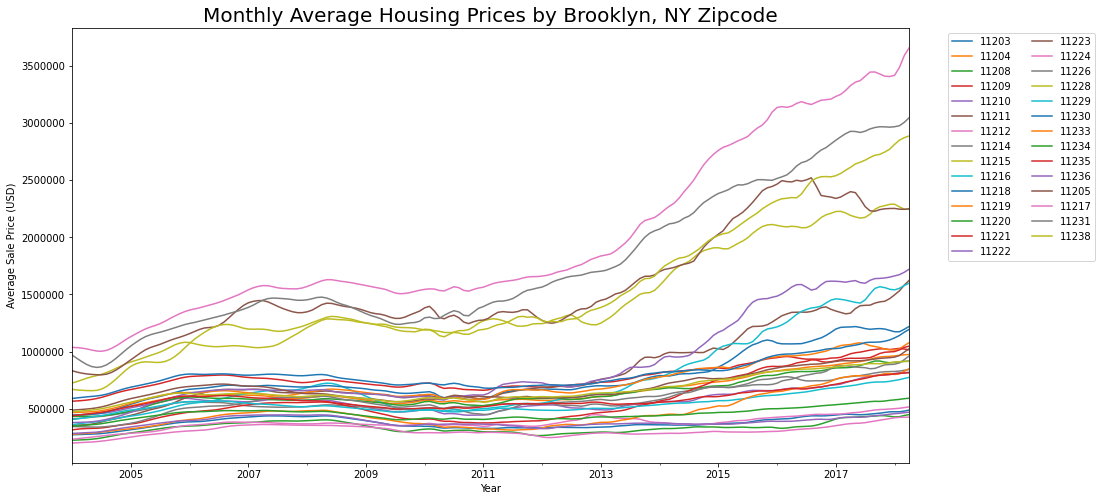

In [205]:
for zipcode in brooklyn_data.RegionName.unique():
    temp_df = brooklyn_data[brooklyn_data.RegionName == zipcode]
    temp_df = temp_df.loc['2004':,]
    temp_df['2004':]['MeanPrice'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);

**Observations of the data:**
- There was a dip in 2008 and 2010 because of the financial crisis, housing price became stable around 2011.
- To get more accurate predictions on the year 2020 and above data, we have decided to use data ranging from 2011-Present.

In [206]:
df_2011 = brooklyn_data['2011':]
month_avg = df_2011.groupby(by = ['Month']).mean()
month_avg = month_avg[['MeanPrice']]
month_avg.head()

,MeanPrice
Month,
2011-01-01,633365.517241
2011-02-01,638334.482759
2011-03-01,647358.620690
2011-04-01,655465.517241
2011-05-01,659955.172414


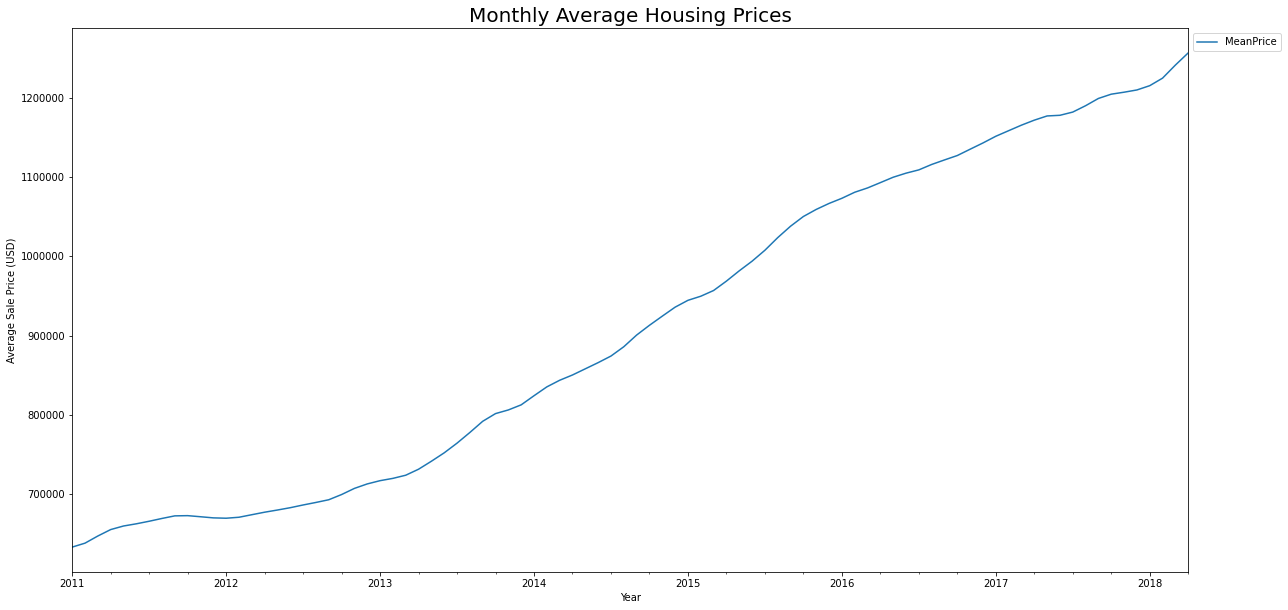

In [207]:
month_avg.plot(figsize = (20,10), label = 'MeanPrice')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ticklabel_format(axis="y", style='plain')
plt.xlabel("Year")
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices', fontsize = 20)
plt.show()

<h2>Seasonal Decomposition for 2011 and above

Let's see if there was seasonal effects on house price.

- Trend: The increasing or decreasing value in the dataset.
- Seasonality: The repeating short-term cycle in the dataset.
- Residual / noise : The random variation in the dataset which remains behind when separated from seasonality and trend from the time series

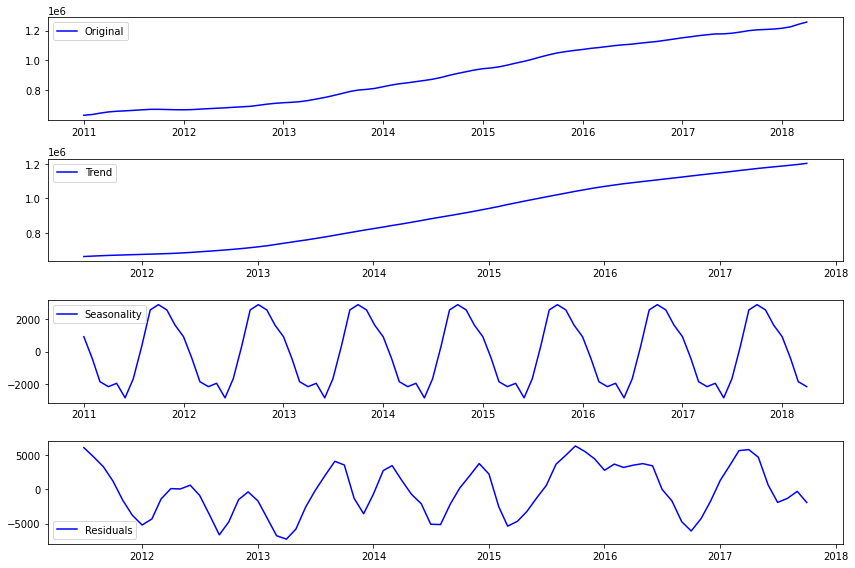

In [208]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model = 'additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot gathered statistics
plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(month_avg, label = 'Original', color = 'blue')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

**Observations of the data:**
- An upward trend is present with yearly seasonal changes.
- Look into residual.

**Dickey Fuller test**

- Dickey Fuller test is used to test stationarity. The null hypothesis is time series is non-stationary, and the alternative hypothesis is time series is stationarary.

In [262]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window = 12, center = False).mean()
    roll_std = TS.rolling(window =12, center = False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)
    print(dftest)
    
     # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [260]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)

(-2.527008427518502, 0.109040403394974, 6, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, 1097.7658712297493)


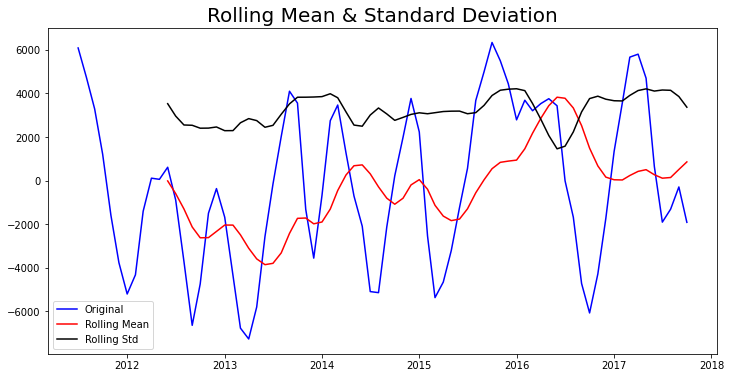

Results of Dickey-Fuller Test: 

Test Statistic                 -2.527008
p-value                         0.109040
#Lags Used                      6.000000
Number of Observations Used    69.000000
dtype: float64
Test Statistic                 -2.527008
p-value                         0.109040
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [279]:
stationarity_check(ts_log_decompose)

**Observations of the data:**
- Mean and standard deviation are not stationary
- The p-value (0.109040) is larger than significance level (0.05). We can accept the null which means the residuals are not stationary.

***

<h2> Autocorrelation Function (ACF) & Partial Autocorrelation Function (PCF)</h2>

- ACF: The correlation between two values in a time series.
- Lag: The number of intervals between the two observations.
- PCF: similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain. For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. 

<Figure size 504x360 with 0 Axes>

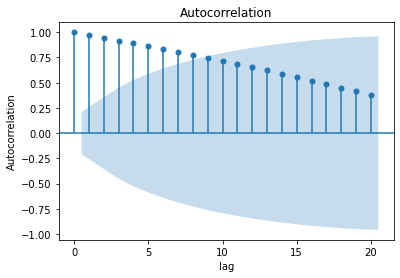

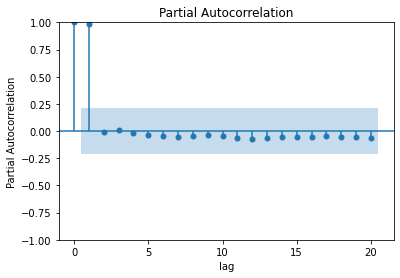

In [212]:
plt.figure(figsize = (7,5))
plot_acf(month_avg) 
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
# plt.xlim(0,24)
plt.show()

plot_pacf(month_avg)
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1, 1)
plt.show()

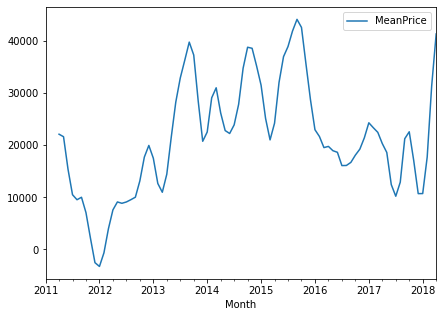

In [213]:
rcParams['figure.figsize'] = 7,5
month_avg.diff(periods=3).plot();

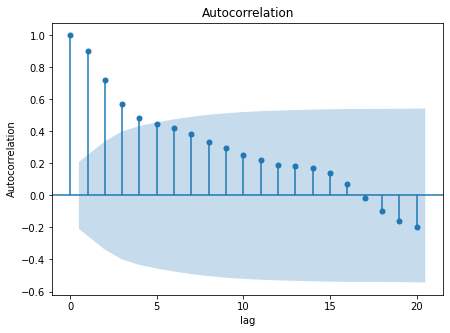

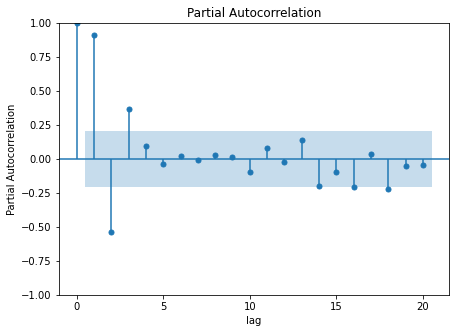

In [214]:
rcParams['figure.figsize'] = 7,5
plot_acf(month_avg.diff(periods=3).bfill())
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
# plt.xlim(0, 24)
plt.show()

plot_pacf(month_avg.diff(periods=3).bfill())
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
# plt.xlim(0, 24)
plt.ylim(-1,1)
plt.show()

# Step 3: Initial SARIMA Models on Sample Zip Codes

<h>Perform SARIMA model on 3 sample zip codes.

In [215]:
brooklyn_data.RegionName.unique()

array([11203, 11204, 11208, 11209, 11210, 11211, 11212, 11214, 11215,
       11216, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11226,
       11228, 11229, 11230, 11233, 11234, 11235, 11236, 11205, 11217,
       11231, 11238], dtype=int64)

In [216]:
zip_dfs = []
zip_list = random.choices(brooklyn_data.RegionName.unique(), k=3)
print(zip_list)

[11228, 11231, 11233]


In [217]:
for x in zip_list:
    zip_dfs.append(pd.DataFrame(brooklyn_data[brooklyn_data['RegionName'] == x][['MeanPrice']]))
 
zip_dfs

[            MeanPrice
 Month                
 1996-04-01   219300.0
 1996-05-01   219600.0
 1996-06-01   219900.0
 1996-07-01   220200.0
 1996-08-01   220600.0
 ...               ...
 2017-12-01   902200.0
 2018-01-01   909000.0
 2018-02-01   912800.0
 2018-03-01   913900.0
 2018-04-01   915300.0
 
 [265 rows x 1 columns],
             MeanPrice
 Month                
 2004-01-01   969500.0
 2004-02-01   940900.0
 2004-03-01   912300.0
 2004-04-01   887300.0
 2004-05-01   869900.0
 ...               ...
 2017-12-01  2961600.0
 2018-01-01  2965300.0
 2018-02-01  2974000.0
 2018-03-01  3004000.0
 2018-04-01  3044500.0
 
 [172 rows x 1 columns],
             MeanPrice
 Month                
 1996-04-01   124500.0
 1996-05-01   124500.0
 1996-06-01   124500.0
 1996-07-01   124500.0
 1996-08-01   124700.0
 ...               ...
 2017-12-01   809800.0
 2018-01-01   800800.0
 2018-02-01   806100.0
 2018-03-01   829200.0
 2018-04-01   852300.0
 
 [265 rows x 1 columns]]

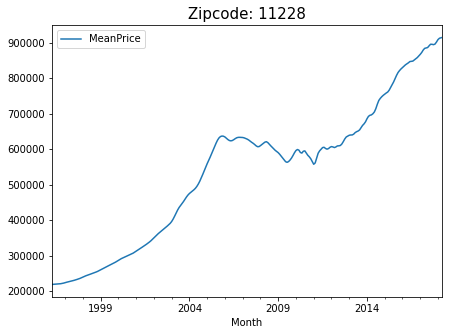

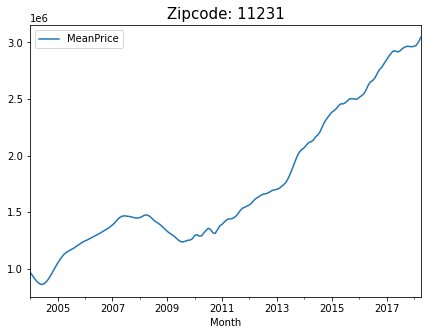

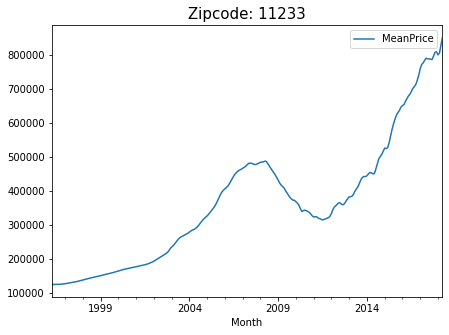

In [218]:
for df,name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(f'Zipcode: {name}', fontsize = 15)
    plt.show()

An ARIMA model is characterized by 3 terms: p, d, q

*   p is the order of the AR term
*   q is the order of the MA term
*   d is the number of differencing required to make the time series stationary

Seasonality
- For monthly data, S = 12 (months per year)
- For quarterly data, S = 4 (time periods per year)

In [219]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [220]:
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [221]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [222]:
#Run SARIMA Model (Kindly note that this might take some time to run)
start = time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, 
                                                                                                     para2, 
                                                                                                     output.aic))
            except:
                continue

Result for 11228 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7753.863905567089
Result for 11228 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7247.519450789267
Result for 11228 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6132.8891698535845
Result for 11228 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5853.1977337320295
Result for 11228 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6012.424722618738
Result for 11228 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5966.958167123234
Result for 11228 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5660.48890439918
Result for 11228 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7623.588176469837
Result for 11228 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7533.779106964506
Result for 11228 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7147.367925403403
Result for 11228 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6171.95564335607
Result for 11228 ARIMA (0, 0, 1)

In [223]:
print('Time Taken: {0} seconds'.format(time.time()-start))

Time Taken: 62.358559370040894 seconds


The **Akaike Information Critera (AIC)** is a widely used measure of a statistical model. It basically quantifies: <br> 
1) the goodness of fit <br>
2) the simplicity/parsimony of the model into a single statistic

When comparing two models, the one with the lower AIC is generally “better”.

In [241]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
result

,name,pdq,pdqs,AIC
0,11203,"(0, 0, 0)","(0, 0, 0, 12)",7459.819283
1,11203,"(0, 0, 0)","(0, 0, 1, 12)",282859.445054
2,11203,"(0, 0, 0)","(0, 1, 0, 12)",5937.587287
3,11203,"(0, 0, 0)","(0, 1, 1, 12)",5667.677554
4,11203,"(0, 0, 0)","(1, 0, 0, 12)",5915.665653
...,...,...,...,...
1851,11238,"(1, 1, 1)","(0, 1, 1, 12)",3127.936511
1852,11238,"(1, 1, 1)","(1, 0, 0, 12)",3314.659689
1853,11238,"(1, 1, 1)","(1, 0, 1, 12)",3295.569654
1854,11238,"(1, 1, 1)","(1, 1, 0, 12)",3151.599587


In [225]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
63,11228,"(1, 1, 1)","(1, 1, 1, 12)",4308.681602
127,11231,"(1, 1, 1)","(1, 1, 1, 12)",3114.322528
191,11233,"(1, 1, 1)","(1, 1, 1, 12)",4533.147251


In [226]:
# Mean house price in Brooklyn is above $1 Million
meanBrooklyn = brooklyn_data['2017':]['MeanPrice'].mean()
print(f"Mean House Price in Brooklyn from 2017 onwards: ${round(meanBrooklyn, 2)}")

Mean House Price in Brooklyn from 2017 onwards: $1195787.93


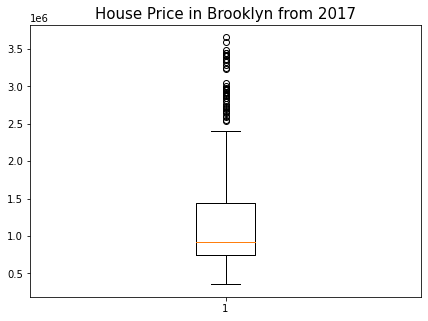

In [227]:
fig1, ax1 = plt.subplots()
ax1.set_title('House Price in Brooklyn from 2017', fontsize=15)
ax1.boxplot(brooklyn_data['2017':]['MeanPrice']);

In [228]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary())
    #print(output.summary().tables[1])

SARIMA Model Result for 11228
                                     SARIMAX Results                                      
Dep. Variable:                          MeanPrice   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2149.341
Date:                            Thu, 19 May 2022   AIC                           4308.682
Time:                                    00:03:17   BIC                           4326.043
Sample:                                04-01-1996   HQIC                          4315.679
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7222      0.042     17.330      0.000       0.640       0.804
ma.L1

***

### Make dynamic forecast using data from 2017-01-01 onwards and compare with real values post 2017-01-01

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


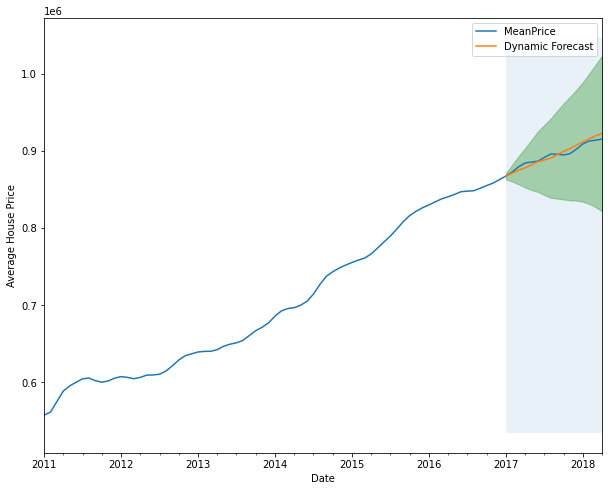

The Mean Squared Error of our forecasts is 4356.83


C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


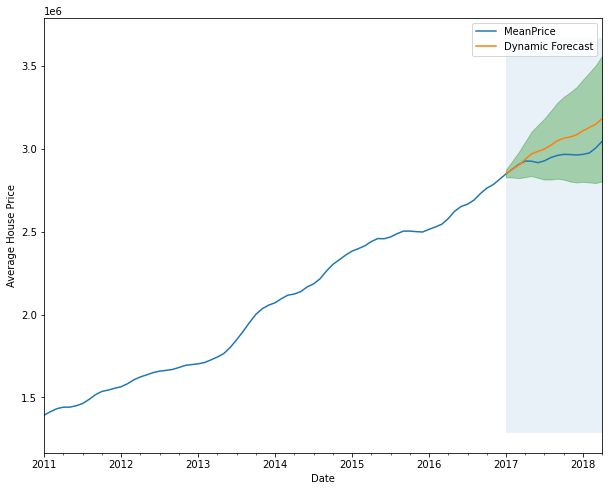

The Mean Squared Error of our forecasts is 94733.22


C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


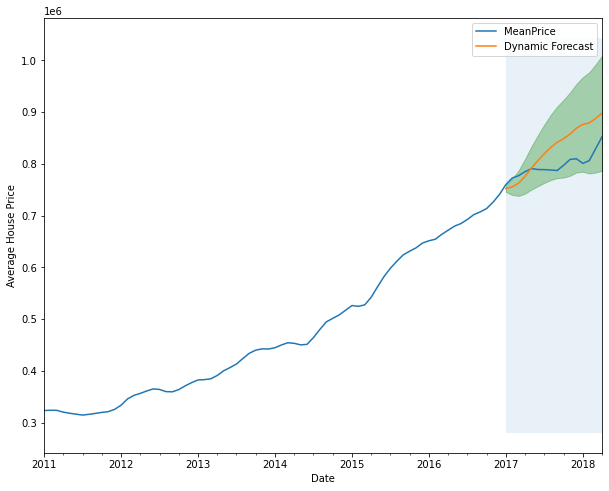

The Mean Squared Error of our forecasts is 44523.02


In [229]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanPrice']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['RMSE'] = MSE_Value

In [230]:
summary_table

,Zipcode,RMSE
0,11228,4356.829603
1,11231,94733.220298
2,11233,44523.023316


#### Producing and Visualizing Forecasts

In [231]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]

for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    
    current.append(df['2018-04']['MeanPrice'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

<ipython-input-231-4b9773849bfc>:15: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  current.append(df['2018-04']['MeanPrice'][0])


In [232]:
forecast_table

,Zipcode,Current Value,3 Years Value,5 Years Value,3Yr-ROI,5Yr-ROI
0,11228,915300.0,1.019894e+06,1.090799e+06,0.114273,0.191739
1,11231,3044500.0,3.764785e+06,4.209853e+06,0.236586,0.382773
2,11233,852300.0,1.182264e+06,1.389166e+06,0.387146,0.629903


***

# Step 4: Run SARIMA models on all Zipcodes

Iterate through all zipcodes.

In [233]:
zip_dfs = []
zip_list = brooklyn_data.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(brooklyn_data[brooklyn_data['RegionName']==x][['MeanPrice']].copy()))

In [234]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [235]:
#Run SARIMA Model (Kindly note that this might take some time to run)
ans = []
start = time.time()

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, 
                                                                                                     para2, 
                                                                                                     output.aic))
            except:
                continue

Result for 11203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7459.8192830201615
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 282859.44505382556
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.5872868449005
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.677553668713
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5915.665653276429
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5857.548269122471
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5534.032764342531
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7216.504823729885
Result for 11203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 32292.280787970903
Result for 11203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 287580.4114668792
Result for 11203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5748.37080913138
Result for 11203 ARIMA (0, 0,

In [236]:
print('Took', time.time()-start, 'seconds.')

Took 688.3164901733398 seconds.


In [242]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [243]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [244]:
best_para.head()

,name,pdq,pdqs,AIC
63,11203,"(1, 1, 1)","(1, 1, 1, 12)",4180.766192
123,11204,"(1, 1, 1)","(0, 1, 1, 12)",4286.602865
1663,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
191,11208,"(1, 1, 1)","(1, 1, 1, 12)",4250.901034
255,11209,"(1, 1, 1)","(1, 1, 1, 12)",4585.735786


#### Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [245]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])

SARIMA Model Result for 11203
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8087      0.046     17.612      0.000       0.719       0.899
ma.L1          0.3367      0.026     13.060      0.000       0.286       0.387
ar.S.L12      -0.4887      0.064     -7.620      0.000      -0.614      -0.363
ma.S.L12      -0.0346      0.041     -0.838      0.402      -0.116       0.046
sigma2      2.616e+06   1.61e+05     16.211      0.000     2.3e+06    2.93e+06
SARIMA Model Result for 11204
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7490      0.042     18.026      0.000       0.668       0.830
ma.L1          0.6234      0.040     15.397      0.000       0.544       0.703
ma.S.L12      -0.2088      0.026     -7.939      0.000      -0.260     

#### Make dynamic forecast from 2017-01-01 onwards and compare with real values

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


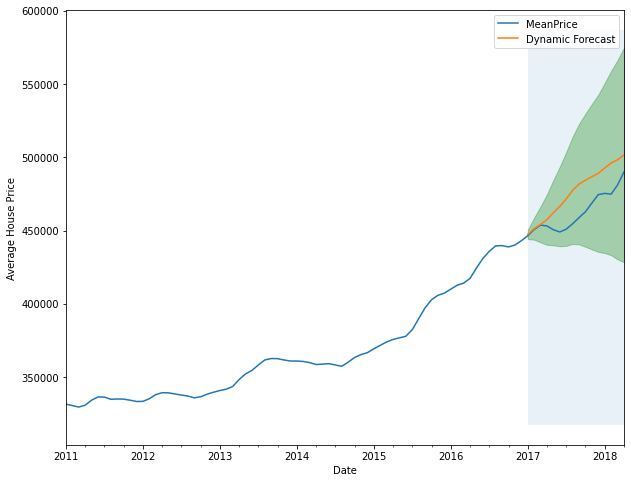

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


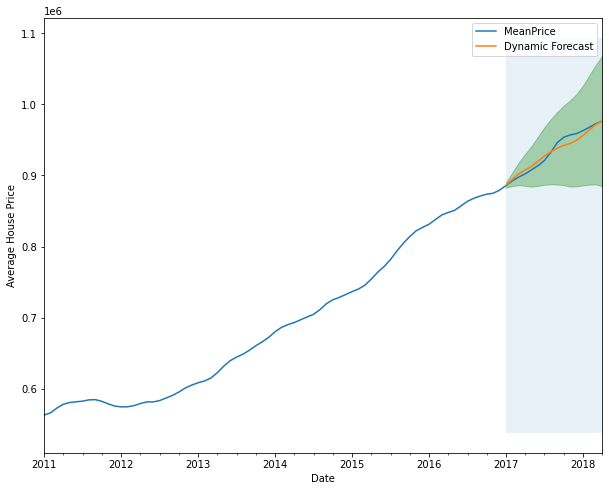

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


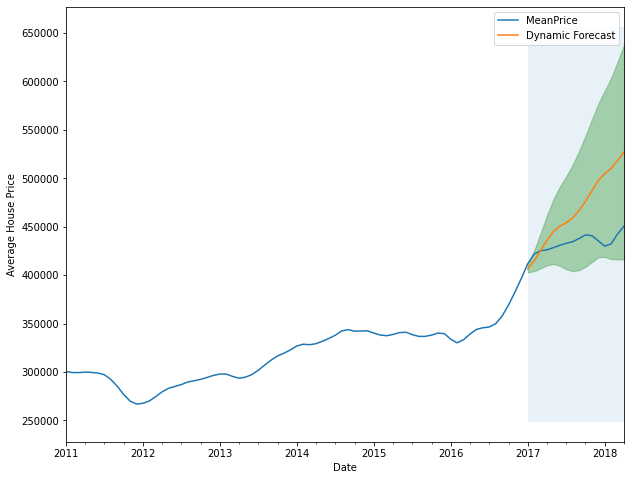

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


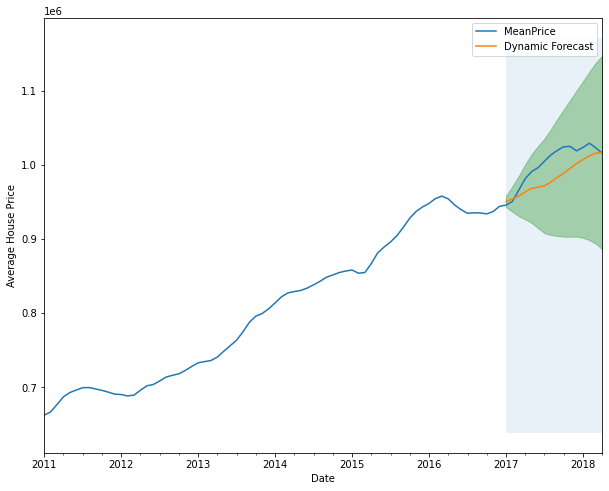

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


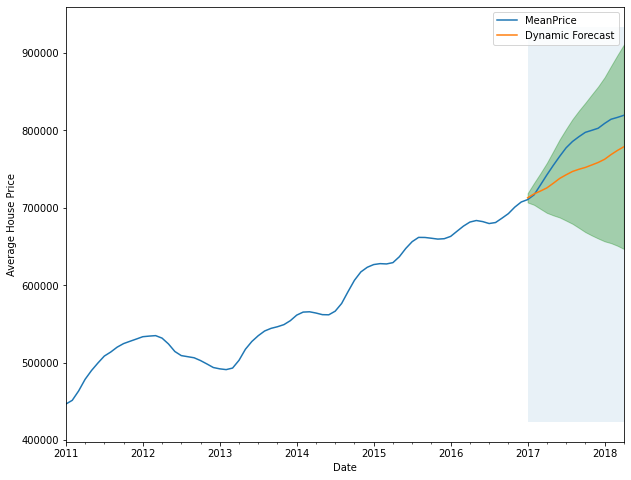

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


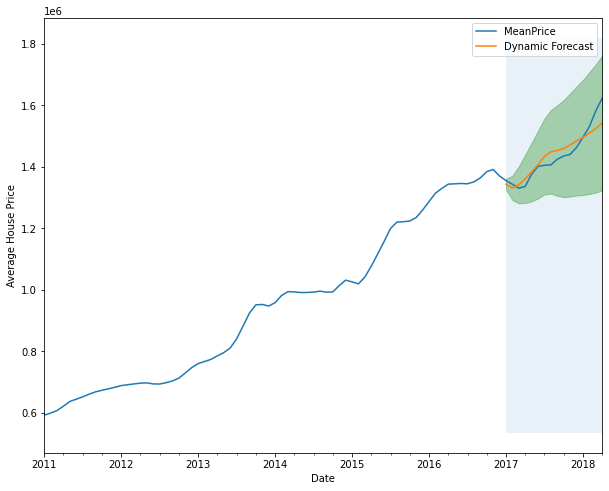

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


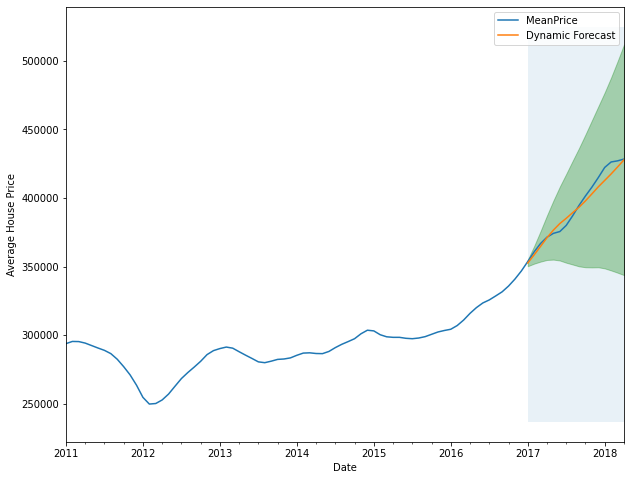

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


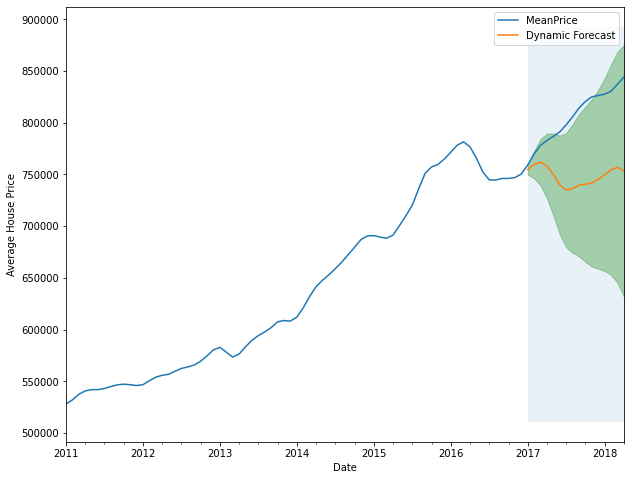

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


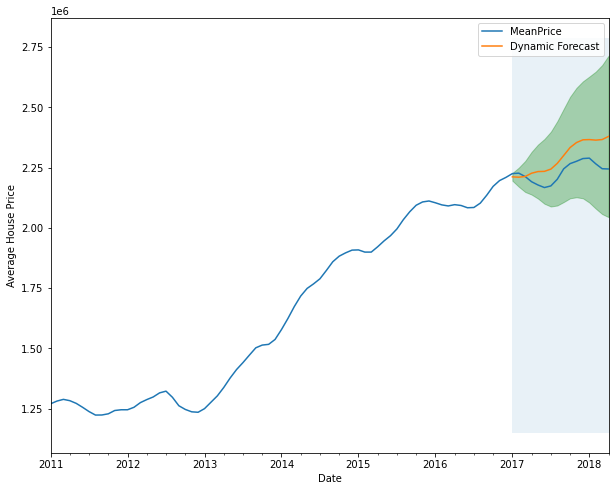

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


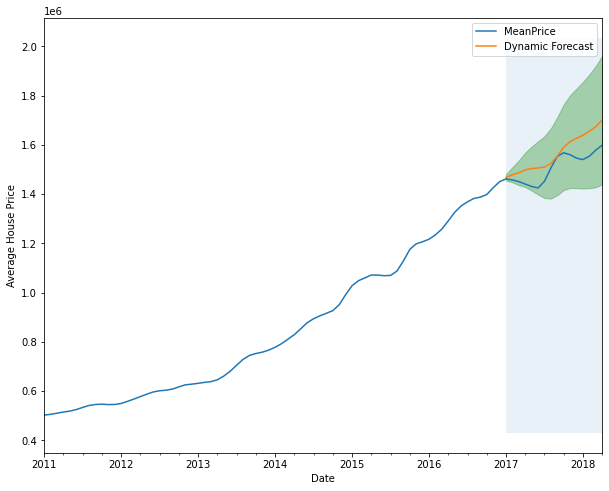

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


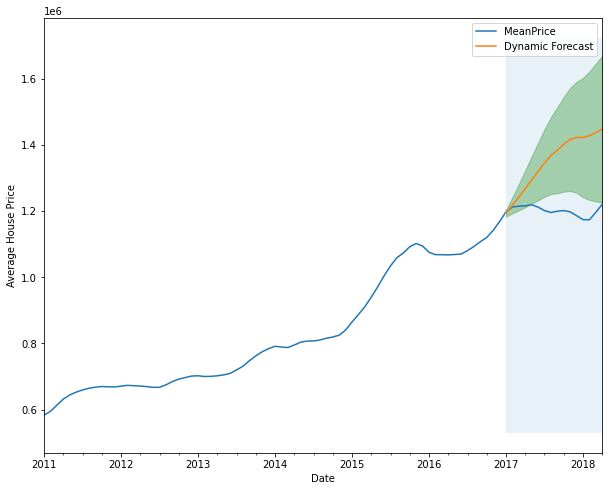

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


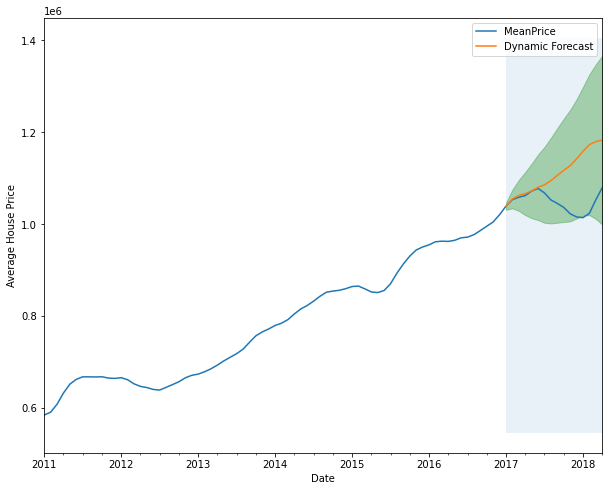

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


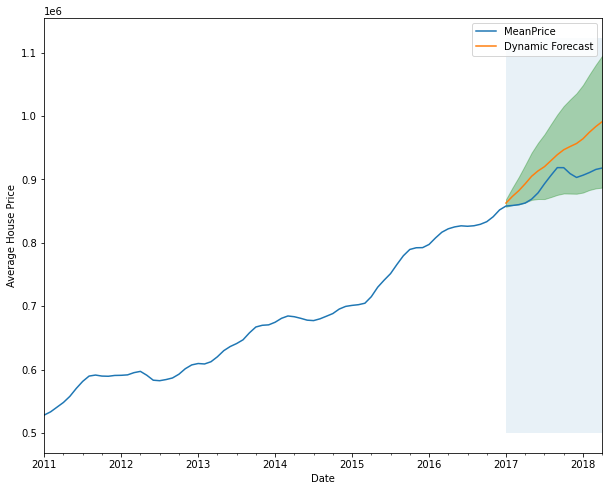

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


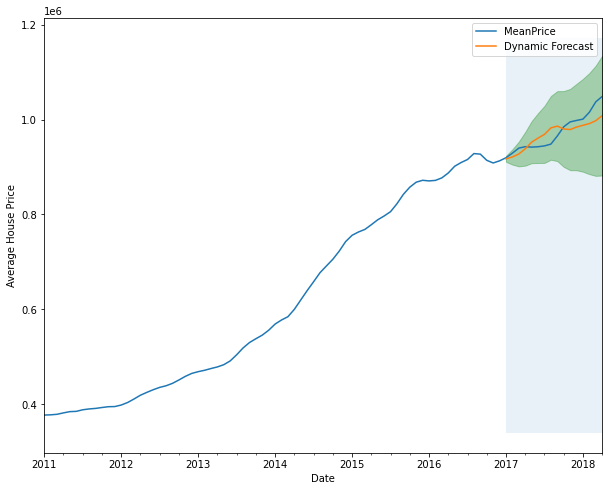

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


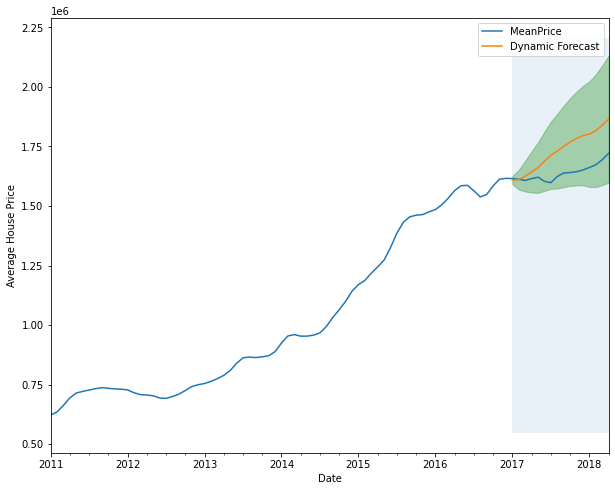

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


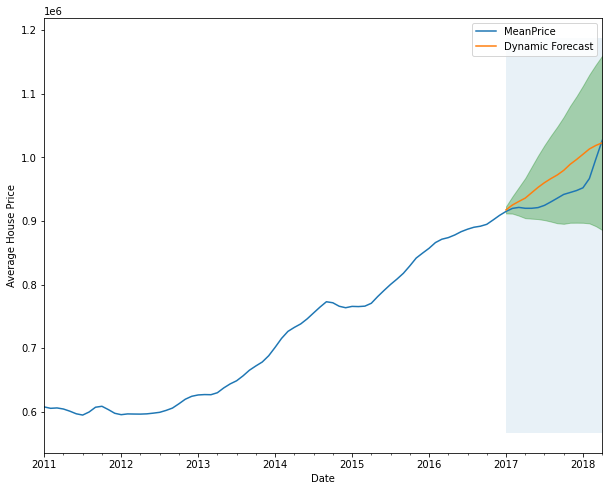

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


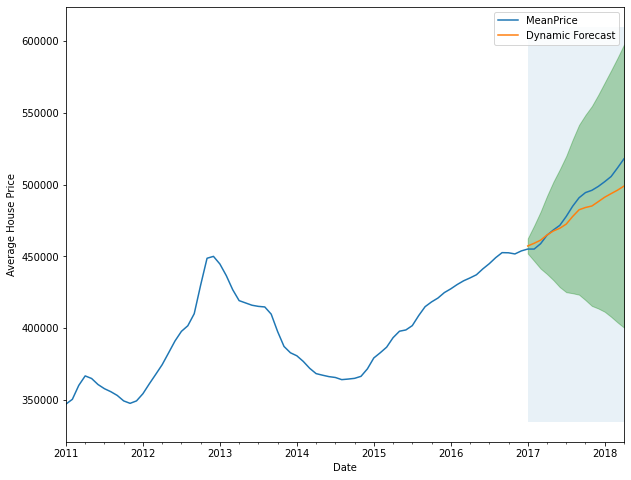

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


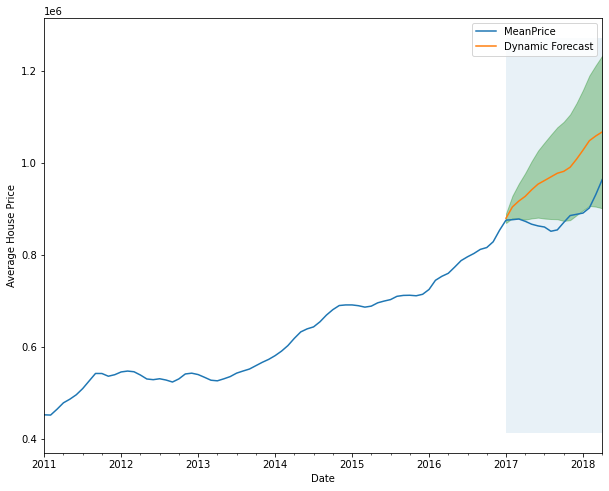

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


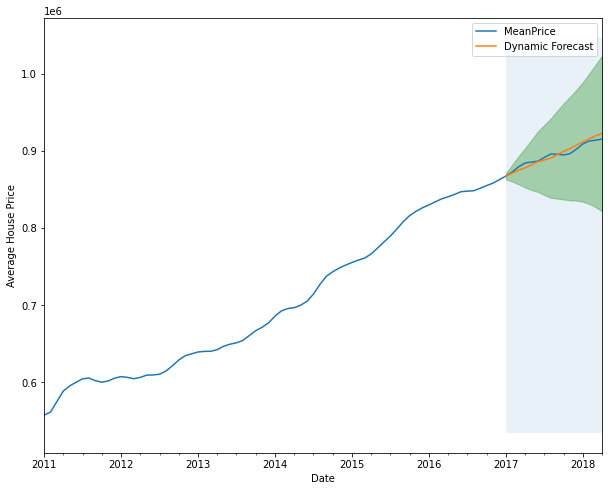

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


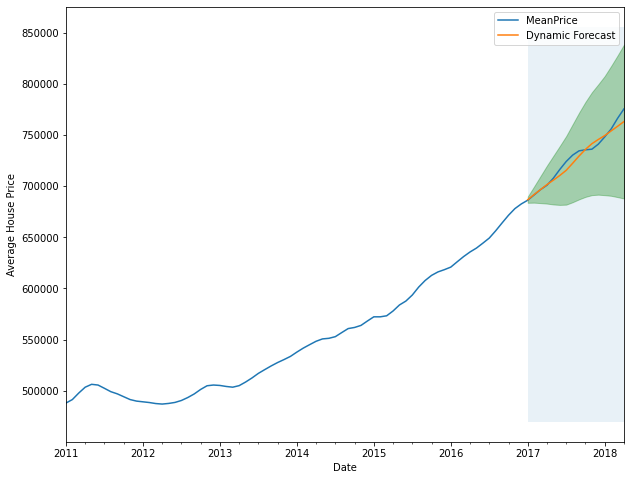

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


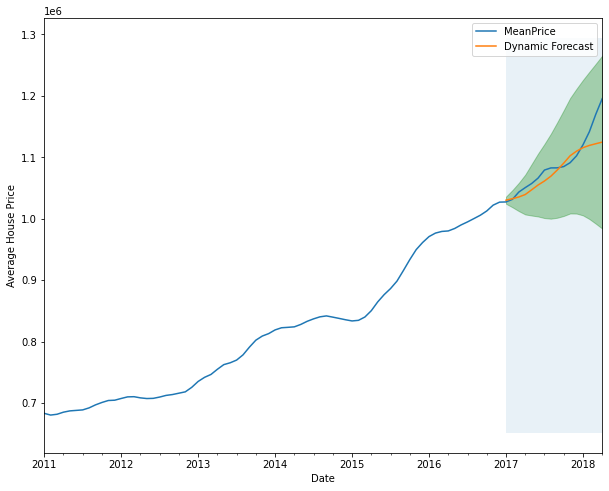

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


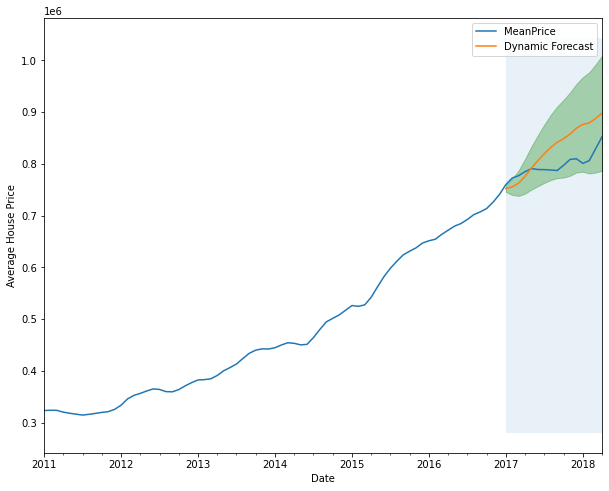

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


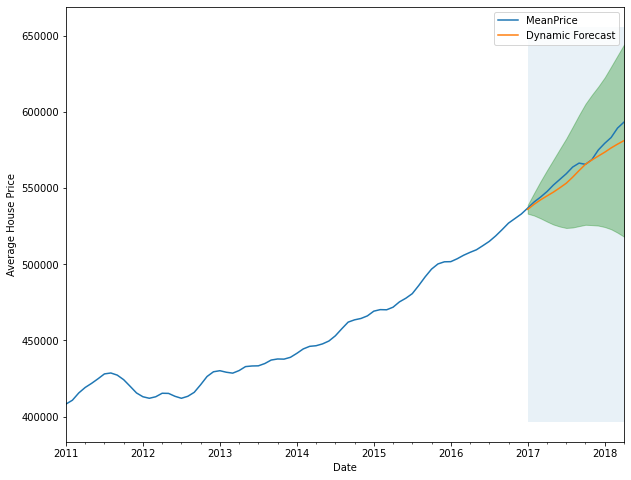

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


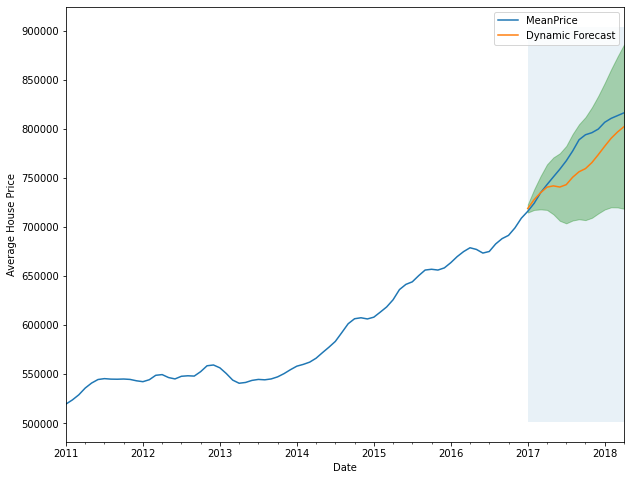

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


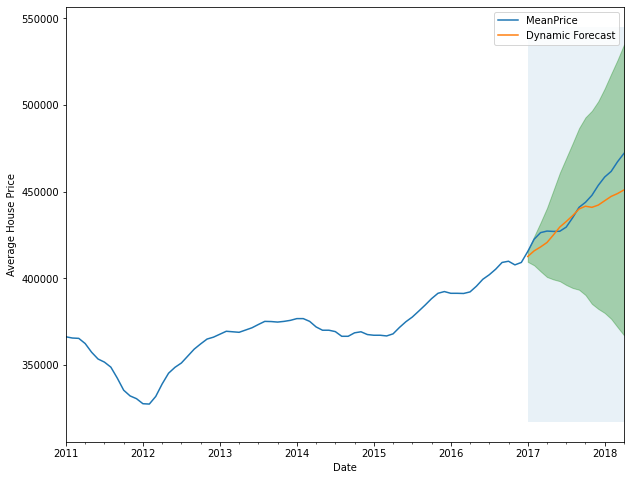

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


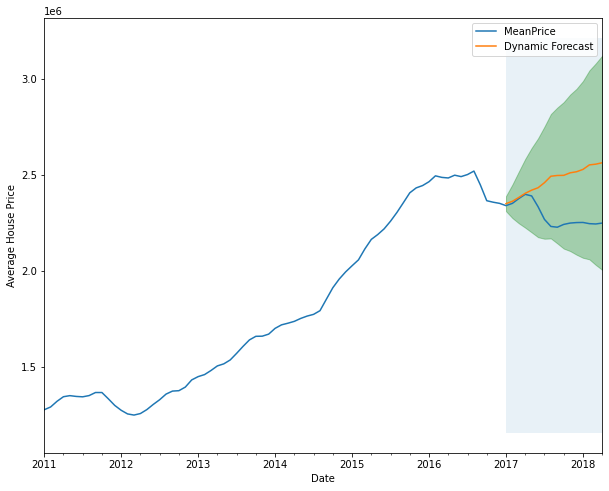

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


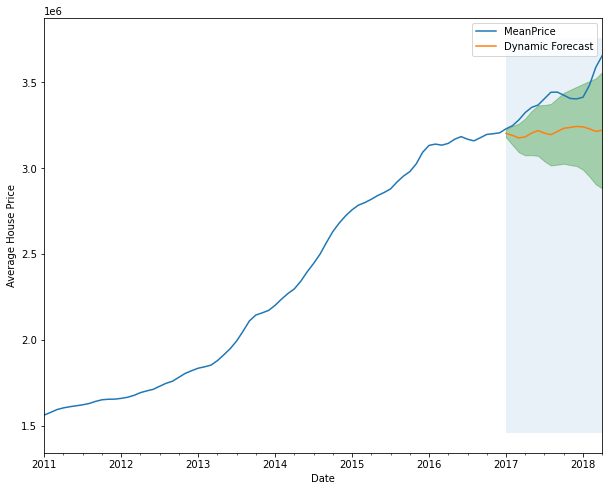

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


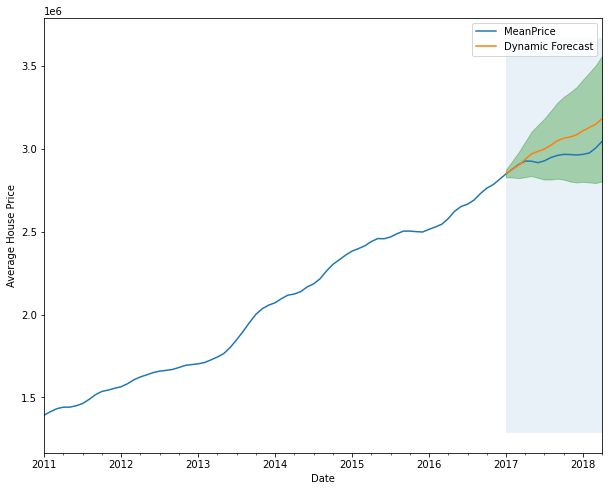

C:\Users\prajw\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


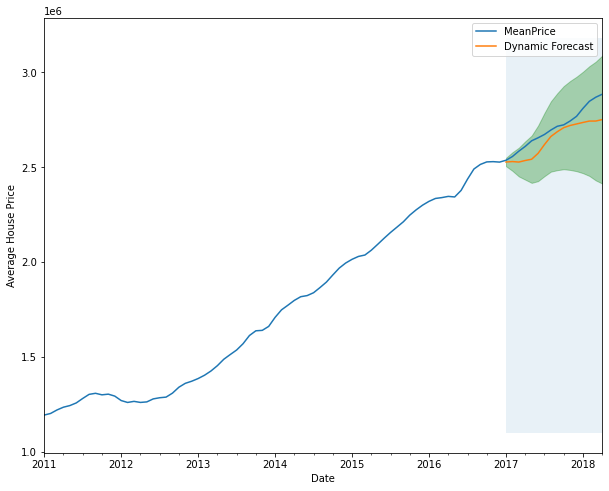

In [246]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanPrice']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['RMSE'] = MSE_Value

In [247]:
#Get the RMSE
summary_table.sort_values('RMSE').head()
#summary_table.head()

,Zipcode,RMSE
18,11224,4356.829603
6,11211,4697.786995
19,11226,5431.747754
22,11230,5749.393729
1,11204,6347.947711


In [248]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanPrice'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

<ipython-input-248-6082b8941324>:18: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  current.append(df['2018-04']['MeanPrice'][0])


,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11203,489900.0,6.746460e+05,7.925614e+05,487226.371698,8.620656e+05,423019.721926,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
1,11204,976400.0,1.173452e+06,1.305639e+06,923829.479078,1.423075e+06,810340.899634,1.800937e+06,0.201815,0.337197,-0.053841,0.457471,-0.170073,0.844467
2,11205,450600.0,5.796279e+05,6.630006e+05,287982.717872,8.712730e+05,107890.111334,1.218111e+06,0.286347,0.471373,-0.360891,0.933584,-0.760563,1.703309
3,11208,1015800.0,1.051716e+06,1.081514e+06,738734.559936,1.364697e+06,479052.537534,1.683976e+06,0.035357,0.064692,-0.272756,0.343471,-0.528399,0.657783
4,11209,819600.0,9.873563e+05,1.104900e+06,659887.055556,1.314826e+06,465565.192713,1.744234e+06,0.204681,0.348096,-0.194867,0.604228,-0.431960,1.128153


#### Top 5 Zip codes with Highest 3Yr-ROI

In [250]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
15,11221,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
20,11228,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
17,11223,963200.0,1.396041e+06,1.669053e+06,9.990354e+05,1.793046e+06,9.218192e+05,2.416287e+06,0.449378,0.732821,0.037205,0.861551,-0.042962,1.508604
21,11229,852300.0,1.182264e+06,1.389166e+06,9.238457e+05,1.440683e+06,8.969124e+05,1.881419e+06,0.387146,0.629903,0.083944,0.690347,0.052344,1.207462
0,11203,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123


#### Top 5 Zip codes with Highest 5Yr-ROI

In [252]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
15,11221,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
20,11228,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
17,11223,963200.0,1.396041e+06,1.669053e+06,9.990354e+05,1.793046e+06,9.218192e+05,2.416287e+06,0.449378,0.732821,0.037205,0.861551,-0.042962,1.508604
21,11229,852300.0,1.182264e+06,1.389166e+06,9.238457e+05,1.440683e+06,8.969124e+05,1.881419e+06,0.387146,0.629903,0.083944,0.690347,0.052344,1.207462
0,11203,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123


# Step 5: Interpret the Results

Based on 3 year return on investment and 5 year return on investment, below 3 zipcodes stand out to be best area to invest in. 11221 and 11228 have a guaranteed positive ROI and could be as high as 87% in 3 years and 154% in 5 years. 
</N>
- 11221: 3Yr ROI: 17%-87%; 5Yr ROI: 16%-154%
- 11228: 3Yr ROI: 16%-78%; 5Yr ROI: 17%-140%
- 11223: 3Yr ROI: 3%-86%; 5Yr ROI: -4%-150%)
<br><br>
However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc.